## Pipeline Tutorial

### install

`Pipeline` is distributed along with [fate_client](https://pypi.org/project/fate-client/).

```bash
pip install fate_client
```

To use Pipeline, we need to first specify which `FATE Flow Service` to connect to. Once `fate_client` installed, one can find an cmd enterpoint name `pipeline`:

In [1]:
!pipeline --help

Usage: pipeline [OPTIONS] COMMAND [ARGS]...

Options:
  --help  Show this message and exit.

Commands:
  init   - DESCRIPTION: Pipeline Config Command.


Assume we have a `FATE Flow Service` in 127.0.0.1:9380(defaults in standalone), then exec

In [2]:
!pipeline init --ip 127.0.0.1 --port 9380

Pipeline configuration succeeded.


### homo nn

The `pipeline` package provides components to compose a `FATE pipeline`.

In [3]:
from pipeline.backend.pipeline import PipeLine
from pipeline.component import DataTransform
from pipeline.component import Reader
from pipeline.component import HomoNN
from pipeline.interface import Data

Make a `pipeline` instance:

    - initiator: 
        * role: guest
        * party: 9999
    - roles:
        * guest: 9999
        * host: [10000, 9999]
        * arbiter: 9999
    

In [4]:
pipeline = PipeLine() \
        .set_initiator(role='guest', party_id=9999) \
        .set_roles(guest=9999, host=[10000], arbiter=10000)

Define a `Reader` to load data

In [5]:
reader_0 = Reader(name="reader_0")
# set guest parameter
reader_0.get_party_instance(role='guest', party_id=9999).component_param(
    table={"name": "breast_homo_guest", "namespace": "experiment"})
# set host parameter
reader_0.get_party_instance(role='host', party_id=10000).component_param(
    table={"name": "breast_homo_host", "namespace": "experiment"})

Add a `DataTransform` component to parse raw data into Data Instance

In [6]:
data_transform_0 = DataTransform(name="data_transform_0", with_label=True)
# set guest parameter
data_transform_0.get_party_instance(role='guest', party_id=9999).component_param(
    with_label=True)
data_transform_0.get_party_instance(role='host', party_id=[10000]).component_param(
    with_label=True)

Now, we define the `HomoNN` component.

In [7]:
homo_nn_0 = HomoNN(
    name="homo_nn_0", 
    max_iter=10, 
    batch_size=-1, 
    early_stop={"early_stop": "diff", "eps": 0.0001})

Add single `Dense` layer:

In [8]:
from tensorflow.keras.layers import Dense
homo_nn_0.add(
    Dense(units=1, input_shape=(10,), activation="sigmoid"))

Compile:

In [9]:
from tensorflow.keras import optimizers
homo_nn_0.compile(
    optimizer=optimizers.Adam(learning_rate=0.05), 
    metrics=["accuracy", "AUC"],
    loss="binary_crossentropy")

Add components to pipeline:

    - data_transform_0 comsume reader_0's output data
    - homo_nn_0 comsume data_transform_0's output data

In [10]:
pipeline.add_component(reader_0)
pipeline.add_component(data_transform_0, data=Data(data=reader_0.output.data))
pipeline.add_component(homo_nn_0, data=Data(train_data=data_transform_0.output.data))
pipeline.compile();

Now, submit(fit) our pipeline:

In [12]:
pipeline.fit()

2020-11-02 17:39:31.756 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:121 - Job id is 2020110217393142628946


Job is still waiting, time elapse: 0:00:00
Running component reader_0, time elapse: 0:00:02
Running component data_transform_0, time elapse: 0:00:04


2020-11-02 17:39:50.461 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:129 - Job is success!!! Job id is 2020110217393142628946
2020-11-02 17:39:50.462 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:130 - Total time: 0:00:18


Success! Now we can get model summary from homo_nn_0:

In [13]:
summary = pipeline.get_component("homo_nn_0").get_summary()
summary

{'is_converged': False,
 'loss_history': [0.45709115266799927,
  0.3215165436267853,
  0.24622784554958344,
  0.19835461676120758,
  0.16508619487285614,
  0.14108890295028687,
  0.12376809120178223,
  0.11123336106538773,
  0.10193527489900589,
  0.09480327367782593]}

And we can use the summary data to draw the loss curve:

Populating the interactive namespace from numpy and matplotlib


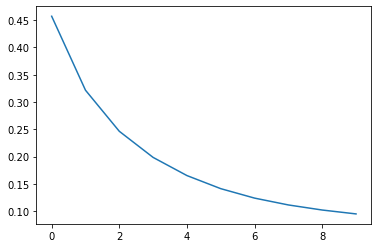

In [14]:
%pylab inline
pylab.plot(summary['loss_history'])

For more examples about using pipeline to submit `HomoNN` jobs, please refer to [HomoNN Examples](https://github.com/FederatedAI/FATE/tree/master/examples/pipeline/homo_nn)